In [247]:
import pandas as pd
import numpy as np
import math
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from time import sleep
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge ,RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, scale
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

In [2]:
chromedriver = "/Users/himanikaushik/Documents/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [3]:
titles = []
years = []
duration = []
imdb_ratings = []
metascores = []
votes = []
us_gross = []
genre = [] 
certificate = [] 

In [4]:
pages = np.arange(1, 3001, 50)
headers = {'Accept-Language': 'en-US, en;q=0.5'}

for page in pages:
    page = requests.get('https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&countries=us&start=' + str(page) + '&ref_=adv_nxt', headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
        
    movie_div = soup.find_all('div', class_='lister-item mode-advanced')
        
    sleep(randint(2,10))
    
    for container in movie_div:
        name = container.h3.a.text
        titles.append(name)
                
        year = container.h3.find('span', class_='lister-item-year text-muted unbold').text
        years.append(year)
                
        runtime = container.find('span', class_='runtime').text if container.p.find('span', class_='runtime') else '-'
        duration.append(runtime)
        
        cert = container.find('span', class_='certificate').text if container.p.find('span', class_='certificate') else '-'
        certificate.append(cert)
        
        gen = container.find('span', class_='genre').text if container.p.find('span', class_='genre') else '-'
        genre.append(gen)
        
        imdb = float(container.strong.text)
        imdb_ratings.append(imdb)
        
        m_score = container.find('span', class_='metascore').text if container.find('span', class_='metascore') else '-'
        metascores.append(m_score)
        
        nv = container.find_all('span', attrs={'name':'nv'})
        vote = nv[0].text
        votes.append(vote)
        grosses = nv[1].text if len(nv) > 1 else '-'
        us_gross.append(grosses)

In [5]:
movies = pd.DataFrame({'Movie':titles,
                       'year':years,
                       'time_minute':duration,
                       'imdb_rating':imdb_ratings,
                       'metascore':metascores,
                       'vote':votes,
                       'gross_earning':us_gross,
                       'certificates': certificate,
                       'genres': genre})

movies.head()

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres
0,Top Gun: Maverick,(2022),130 min,8.6,78,"141,095",-,PG-13,"\nAction, Drama"
1,Top Gun,(1986),110 min,6.9,50,"366,919",$179.80M,PG,"\nAction, Drama"
2,Fantastic Beasts: The Secrets of Dumbledore,(2022),142 min,6.2,47,"88,369",-,PG-13,"\nAction, Adventure, Fantasy"
3,Everything Everywhere All at Once,(2022),139 min,8.3,81,"106,599",-,R,"\nAction, Adventure, Comedy"
4,Doctor Strange in the Multiverse of Madness,(2022),126 min,7.3,60,"201,185",-,PG-13,"\nAction, Adventure, Fantasy"


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie          3000 non-null   object 
 1   year           3000 non-null   object 
 2   time_minute    3000 non-null   object 
 3   imdb_rating    3000 non-null   float64
 4   metascore      3000 non-null   object 
 5   vote           3000 non-null   object 
 6   gross_earning  3000 non-null   object 
 7   certificates   3000 non-null   object 
 8   genres         3000 non-null   object 
dtypes: float64(1), object(8)
memory usage: 211.1+ KB


In [7]:
movies.iloc[0:3000]

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres
0,Top Gun: Maverick,(2022),130 min,8.6,78,"141,095",-,PG-13,"\nAction, Drama"
1,Top Gun,(1986),110 min,6.9,50,"366,919",$179.80M,PG,"\nAction, Drama"
2,Fantastic Beasts: The Secrets of Dumbledore,(2022),142 min,6.2,47,"88,369",-,PG-13,"\nAction, Adventure, Fantasy"
3,Everything Everywhere All at Once,(2022),139 min,8.3,81,"106,599",-,R,"\nAction, Adventure, Comedy"
4,Doctor Strange in the Multiverse of Madness,(2022),126 min,7.3,60,"201,185",-,PG-13,"\nAction, Adventure, Fantasy"
...,...,...,...,...,...,...,...,...,...
2995,The Big Sleep,(1946),114 min,7.9,86,"84,865",$6.54M,Passed,"\nCrime, Film-Noir, Mystery"
2996,Mr. Holland's Opus,(1995),143 min,7.3,59,"39,009",$82.57M,PG,"\nDrama, Music"
2997,Star Trek: Nemesis,(2002),116 min,6.4,51,"78,743",$43.25M,PG-13,"\nAction, Adventure, Sci-Fi"
2998,Dangerous Liaisons,(1988),119 min,7.6,74,"69,482",$34.70M,R,"\nDrama, Romance"


In [8]:
len(movies.gross_earning.notnull())

3000

In [9]:
#movies.gross_earning.value_counts(dropna=False)

In [16]:
movies.to_csv('The_imdb_dataset.csv', encoding = 'utf-8', index=False)

In [17]:
#EDA 

In [353]:
df_movies = pd.read_csv('The_imdb_dataset.csv')

In [354]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie          3000 non-null   object 
 1   year           3000 non-null   object 
 2   time_minute    3000 non-null   object 
 3   imdb_rating    3000 non-null   float64
 4   metascore      3000 non-null   object 
 5   vote           3000 non-null   object 
 6   gross_earning  3000 non-null   object 
 7   certificates   3000 non-null   object 
 8   genres         3000 non-null   object 
dtypes: float64(1), object(8)
memory usage: 211.1+ KB


In [355]:
df_movies.head()

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres
0,Top Gun: Maverick,(2022),130 min,8.6,78,"141,095",-,PG-13,"\nAction, Drama"
1,Top Gun,(1986),110 min,6.9,50,"366,919",$179.80M,PG,"\nAction, Drama"
2,Fantastic Beasts: The Secrets of Dumbledore,(2022),142 min,6.2,47,"88,369",-,PG-13,"\nAction, Adventure, Fantasy"
3,Everything Everywhere All at Once,(2022),139 min,8.3,81,"106,599",-,R,"\nAction, Adventure, Comedy"
4,Doctor Strange in the Multiverse of Madness,(2022),126 min,7.3,60,"201,185",-,PG-13,"\nAction, Adventure, Fantasy"


In [356]:
#data cleaning

In [357]:
df_movies['time_minute'] = df_movies['time_minute'].str.replace("min",'')
df_movies['time_minute'] = df_movies['time_minute'].astype(int)
df_movies['vote'] = df_movies['vote'].str.replace(",",'')
df_movies['vote'] = df_movies['vote'].astype(int)
df_movies['vote'] = df_movies['vote'].astype(int)
df_movies['genres'] = df_movies['genres'].str.replace("\n",'')

In [358]:
df_movies.loc[df_movies['metascore'] == '-']

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres
201,The Silencing,(2020),93,6.2,-,22718,-,R,"Action, Crime, Mystery"
254,Kama Sutra: A Tale of Love,(1996),114,6.0,-,10642,$4.11M,R,"Crime, Drama, History"
311,House on Haunted Hill,(1959),75,6.8,-,26968,-,Not Rated,"Crime, Horror, Mystery"
455,Bad Day at Black Rock,(1955),81,7.7,-,21755,-,Passed,"Crime, Drama, Mystery"
528,Megan Is Missing,(2011),85,4.6,-,12162,-,Not Rated,"Drama, Horror, Thriller"
...,...,...,...,...,...,...,...,...,...
2896,Little Giants,(1994),107,6.4,-,28623,$19.29M,PG,"Comedy, Family, Sport"
2908,Syrup,(I) (2013),90,5.5,-,12004,$0.00M,R,"Comedy, Drama, Romance"
2913,Out of the Past,(1947),97,8.0,-,36823,-,Not Rated,"Crime, Drama, Film-Noir"
2928,The Horse Soldiers,(1959),120,7.1,-,10445,$1.75M,Approved,"Adventure, Romance, War"


In [359]:
df_movies.loc[df_movies['gross_earning'] == '-']

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres
0,Top Gun: Maverick,(2022),130,8.6,78,141095,-,PG-13,"Action, Drama"
2,Fantastic Beasts: The Secrets of Dumbledore,(2022),142,6.2,47,88369,-,PG-13,"Action, Adventure, Fantasy"
3,Everything Everywhere All at Once,(2022),139,8.3,81,106599,-,R,"Action, Adventure, Comedy"
4,Doctor Strange in the Multiverse of Madness,(2022),126,7.3,60,201185,-,PG-13,"Action, Adventure, Fantasy"
5,The Northman,(2022),137,7.3,82,117083,-,R,"Action, Adventure, Drama"
...,...,...,...,...,...,...,...,...,...
2954,Inheritance,(I) (2020),111,5.5,31,12965,-,TV-MA,"Drama, Mystery, Thriller"
2959,The Dark and the Wicked,(2020),95,6.1,72,15821,-,Not Rated,Horror
2971,The Way Back,(I) (2020),108,6.7,66,44835,-,R,"Drama, Sport"
2985,War Machine,(2017),122,6.0,56,46179,-,TV-MA,"Comedy, Drama, War"


In [360]:
df_movies['metascore'] =df_movies['metascore'].astype(str).str.replace("-", "0")

In [361]:
df_movies['metascore'] = df_movies['metascore'].astype(int)

In [362]:
df_movies_new=df_movies.iloc[0:3000]

In [363]:
df_movies_new.shape

(3000, 9)

In [364]:
df_movies_new['year'] = df_movies_new['year'].str.strip('()').astype(str)
df_movies_new['year'] =df_movies_new['year'].astype(str).str.replace("I", "")
df_movies_new['year'] =df_movies_new['year'].astype(str).str.replace("(", "")
df_movies_new['year'] =df_movies_new['year'].astype(str).str.replace(")","")
df_movies_new['year'] =df_movies_new['year'].astype(str).str.replace("X","")
df_movies_new['year'] =df_movies_new['year'].astype(str).str.replace("V","")

df_movies_new['year'] =df_movies_new['year'].astype(int)

In [365]:
df_movies_new['year'].dtype

dtype('int64')

In [366]:
df_movies_new['gross_earning'] = df_movies_new['gross_earning'].str.strip('$').astype(str)
df_movies_new['gross_earning'] =df_movies_new['gross_earning'].astype(str).str.replace("-", "0")

In [367]:
df_movies_new['gross_earning']

0             0
1       179.80M
2             0
3             0
4             0
         ...   
2995      6.54M
2996     82.57M
2997     43.25M
2998     34.70M
2999     67.64M
Name: gross_earning, Length: 3000, dtype: object

In [368]:
def text_to_num(text, bad_data_val = 0):
    d = {
        'K': 1000,
        'M': 1000000,
        'B': 1000000000
    }
    if not isinstance(text, str):
        return bad_data_val

    elif text[-1] in d:
        num, magnitude = text[:-1], text[-1]
        return int(float(num) * d[magnitude])
    else:
        return float(text)

In [369]:
df_movies_new['gross_earning'] = df_movies_new['gross_earning'].apply(text_to_num)

In [370]:
df_movies_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie          3000 non-null   object 
 1   year           3000 non-null   int64  
 2   time_minute    3000 non-null   int64  
 3   imdb_rating    3000 non-null   float64
 4   metascore      3000 non-null   int64  
 5   vote           3000 non-null   int64  
 6   gross_earning  3000 non-null   float64
 7   certificates   3000 non-null   object 
 8   genres         3000 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 211.1+ KB


In [371]:
df_movies_new = df_movies_new[df_movies_new.year != 2022]

In [372]:
df_movies_new.shape

(2953, 9)

In [373]:
df_movies_new.drop_duplicates(subset=["Movie", "year", "time_minute"], inplace=True)

In [374]:
df_movies_new.shape

(2953, 9)

In [375]:
df_movies_new.loc[df_movies_new['metascore'] == 0]

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres
201,The Silencing,2020,93,6.2,0,22718,0.0,R,"Action, Crime, Mystery"
254,Kama Sutra: A Tale of Love,1996,114,6.0,0,10642,4110000.0,R,"Crime, Drama, History"
311,House on Haunted Hill,1959,75,6.8,0,26968,0.0,Not Rated,"Crime, Horror, Mystery"
455,Bad Day at Black Rock,1955,81,7.7,0,21755,0.0,Passed,"Crime, Drama, Mystery"
528,Megan Is Missing,2011,85,4.6,0,12162,0.0,Not Rated,"Drama, Horror, Thriller"
...,...,...,...,...,...,...,...,...,...
2896,Little Giants,1994,107,6.4,0,28623,19290000.0,PG,"Comedy, Family, Sport"
2908,Syrup,2013,90,5.5,0,12004,0.0,R,"Comedy, Drama, Romance"
2913,Out of the Past,1947,97,8.0,0,36823,0.0,Not Rated,"Crime, Drama, Film-Noir"
2928,The Horse Soldiers,1959,120,7.1,0,10445,1750000.0,Approved,"Adventure, Romance, War"


In [376]:
#metascore and gross earnings have zero values. checking for outliers to find best way to replace zero.

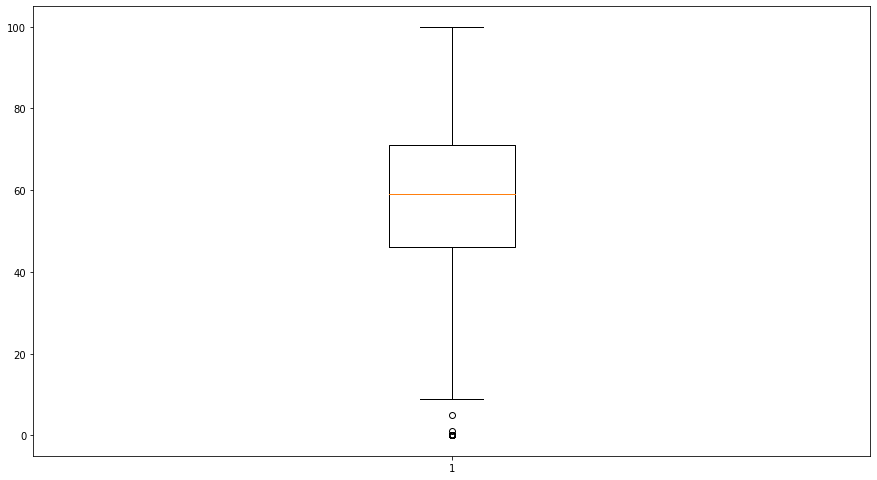

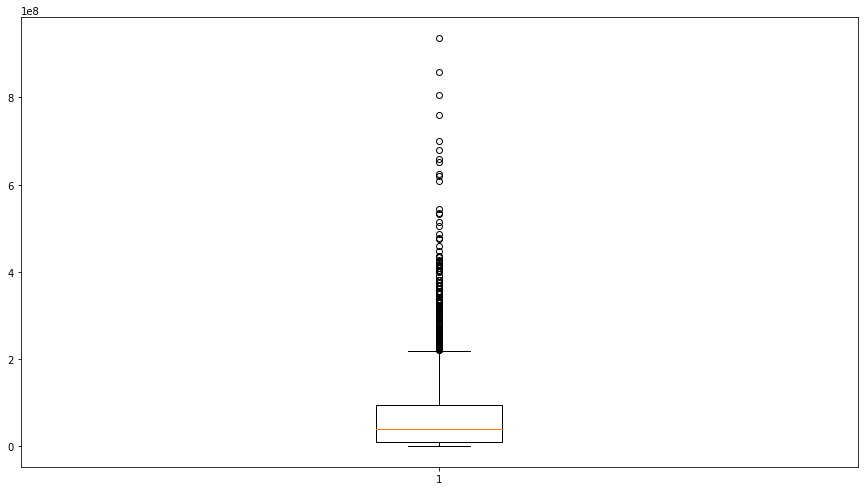

In [377]:
plt.boxplot(df_movies_new['metascore']) 
plt.show()
plt.boxplot(df_movies_new['gross_earning'])
plt.show()

In [378]:
print(df_movies_new['metascore'].mean())

57.62411107348459


In [379]:
df_movies_new['metascore']=df_movies_new['metascore'].replace(0,df_movies_new['metascore'].mean())

In [380]:
print(df_movies_new['gross_earning'].median())

40900000.0


In [381]:
df_movies_new['gross_earning']=df_movies_new['gross_earning'].replace(0,df_movies_new['gross_earning'].median())

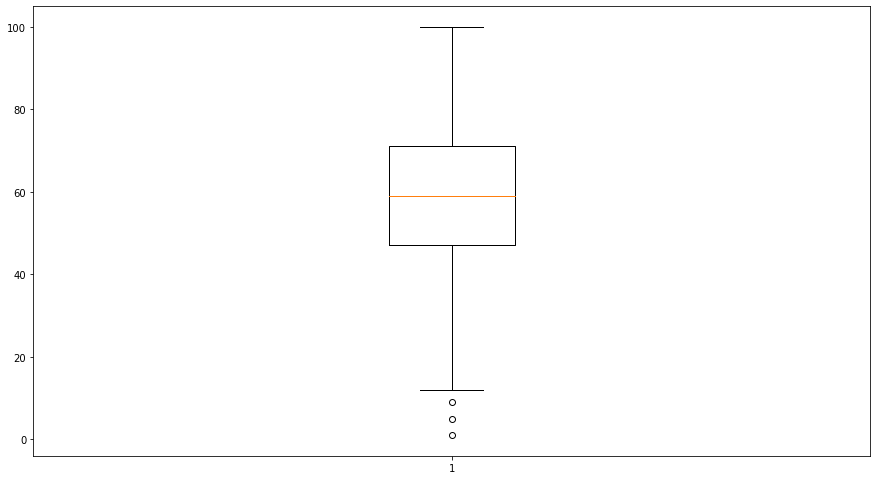

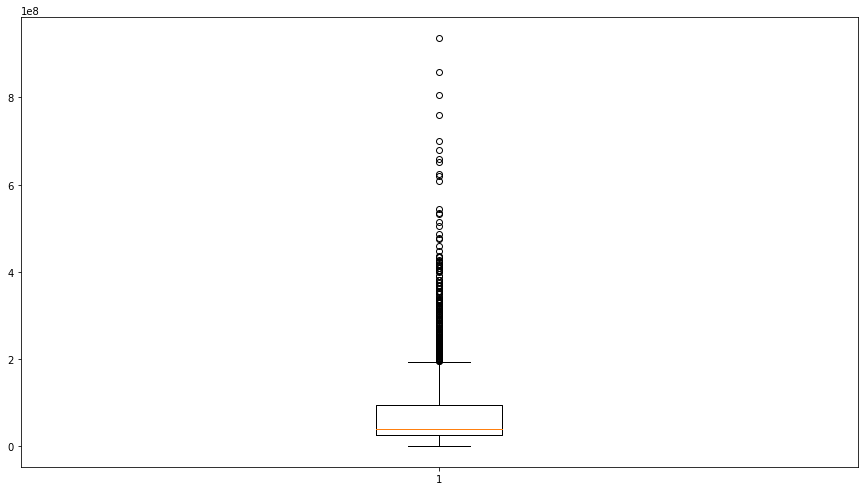

In [382]:
plt.boxplot(df_movies_new['metascore']) 
plt.show()
plt.boxplot(df_movies_new['gross_earning'])
plt.show()

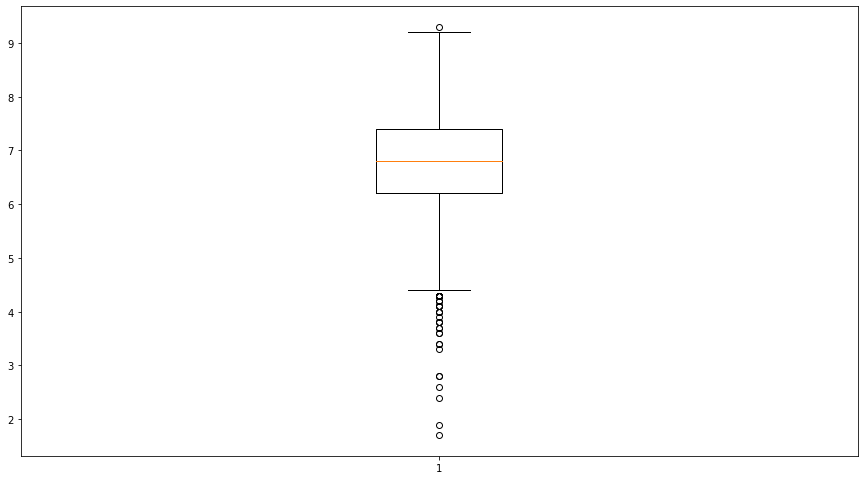

In [383]:
plt.boxplot(df_movies_new['imdb_rating'])
plt.show()

In [384]:
df_movies_new.isnull().values.any()

False

In [385]:
#visualizations

In [386]:
df_subset1=df_movies_new[['Movie','gross_earning','time_minute', 'metascore','vote']]
df_subset1.head(10)

,Movie,gross_earning,time_minute,metascore,vote
1,Top Gun,179800000.0,110,50.0,366919
15,Aquaman,335060000.0,143,55.0,456355
17,Fantastic Beasts: The Crimes of Grindelwald,159560000.0,134,52.0,272543
18,The Godfather,134970000.0,175,100.0,1792213
20,Old,40900000.0,108,55.0,104474
21,The Rum Diary,13100000.0,119,56.0,104425
23,Operation Mincemeat,40900000.0,128,65.0,14322
24,Ghostbusters: Afterlife,40900000.0,124,45.0,154556
25,Spider-Man: No Way Home,804750000.0,148,71.0,651748
26,Willow,57270000.0,126,47.0,112218


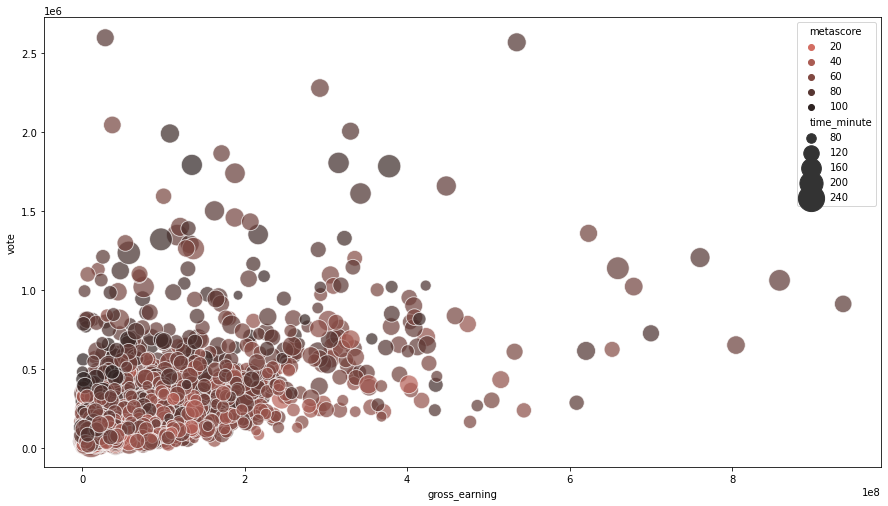

In [387]:
sns.scatterplot(data=df_subset1, x="gross_earning", y="vote",hue='metascore' ,size='time_minute',alpha=0.7, sizes=(50, 800), palette='dark:salmon_r')

sns.color_palette("dark:salmon_r", as_cmap=True)
rcParams['figure.figsize'] = 15, 8.27
plt.show()

In [388]:
df_subset2 = df_movies_new.groupby(['Movie'])[['vote']].sum().sort_values(by ='vote', ascending = False).reset_index()
df_subset2.head(21)

,Movie,vote
0,The Shawshank Redemption,2596857
1,The Dark Knight,2568018
2,Inception,2278668
3,Fight Club,2044949
4,Forrest Gump,2005580
5,Pulp Fiction,1990948
6,The Matrix,1864973
7,The Lord of the Rings: The Fellowship of the Ring,1804981
8,The Godfather,1792213
9,The Lord of the Rings: The Return of the King,1783871


/var/folders/hl/rqh079pj18lfp9br87scnj8m0000gn/T/ipykernel_13153/559482153.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(xlabels)


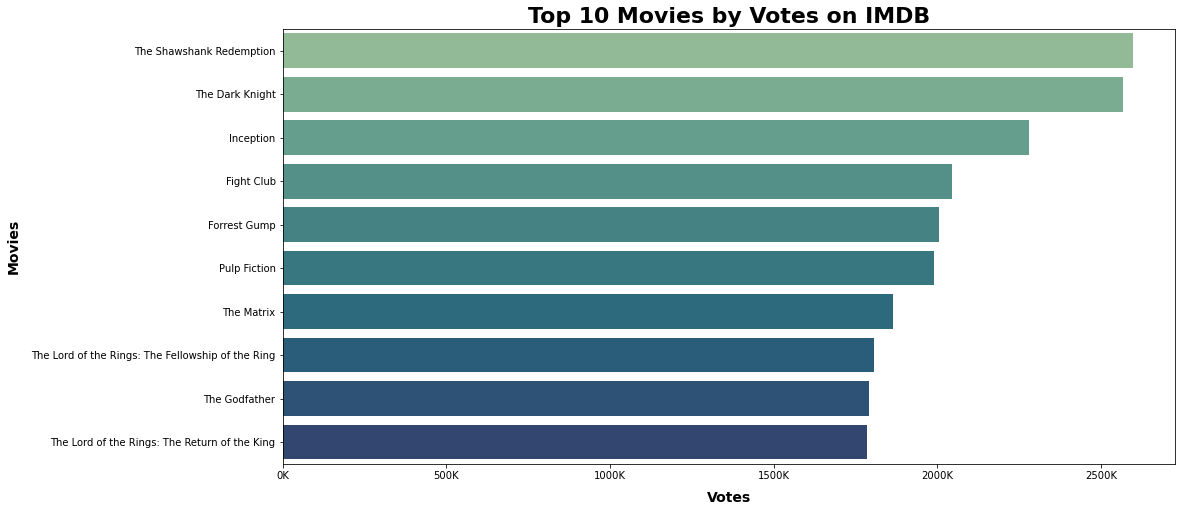

In [389]:
plt.figure(figsize=(16,8))
chart = sns.barplot(x='vote', y='Movie', data=df_subset2.head(10),
            order=df_subset2['Movie'].head(10), palette='crest')
xlabels = [str(int(x))+'K' for x in chart.get_xticks()/1000]
chart.set_xticklabels(xlabels)
chart.set_ylabel('Movies', fontsize=14, fontweight='bold', labelpad=10)
chart.set_xlabel('Votes', fontsize=14, fontweight='bold',labelpad=10)
plt.title('Top 10 Movies by Votes on IMDB', fontsize=22, fontweight='bold')
plt.show()

In [390]:
df_movies_new.corr()

,year,time_minute,imdb_rating,metascore,vote,gross_earning
year,1.000000,-0.054845,-0.297144,-0.211903,0.006766,0.107279
time_minute,-0.054845,1.000000,0.370503,0.249742,0.322940,0.217790
imdb_rating,-0.297144,0.370503,1.000000,0.705820,0.516467,0.180162
metascore,-0.211903,0.249742,0.705820,1.000000,0.332939,0.134681
vote,0.006766,0.322940,0.516467,0.332939,1.000000,0.546708
gross_earning,0.107279,0.217790,0.180162,0.134681,0.546708,1.000000


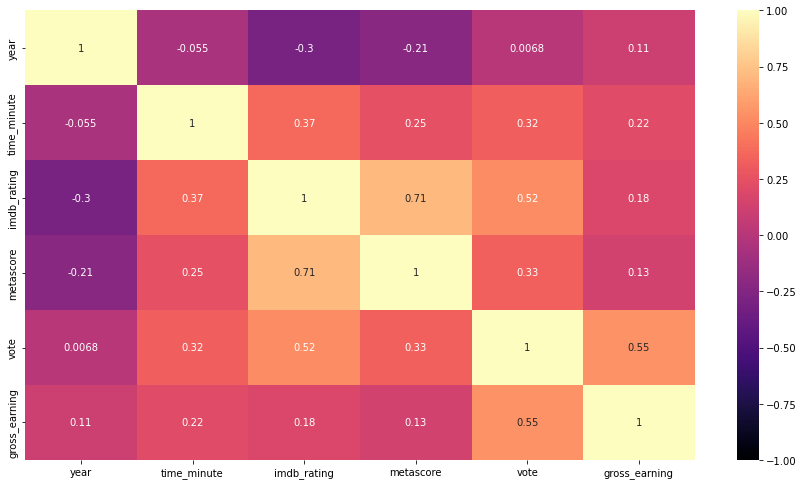

In [391]:
sns.heatmap(df_movies_new.corr(), cmap="magma", annot=True, vmin=-1, vmax=1);

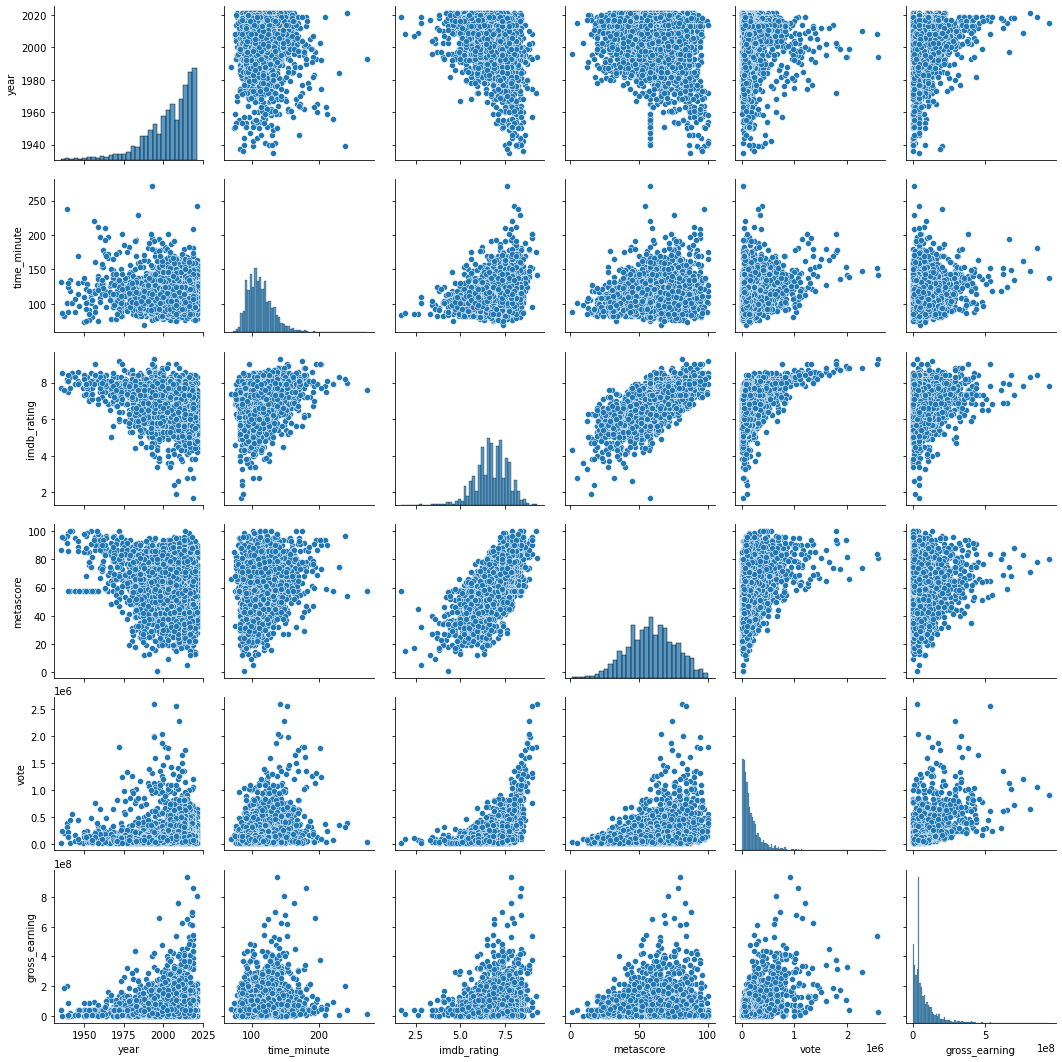

In [392]:
sns.pairplot(data = df_movies_new, corner = False)

In [393]:
#removing white spaces from columns

In [394]:
def strip(names):
    stripped = []
    for name in names:
        stripped.append(name.strip())
    return stripped

In [395]:
df_movies_new.columns = strip(df_movies_new.columns)

In [396]:
#feature engineering
#converting features to dummy variables - 'certificates'

In [397]:
df_movies_new['certificates'] =df_movies_new['certificates'].astype(str).str.replace("Not Rated", "Unrated")
df_movies_new['certificates'].value_counts()

R           1339
PG-13        952
PG           430
G             72
TV-MA         46
Unrated       45
Approved      22
Passed        18
TV-14         10
NC-17          7
GP             5
-              4
TV-PG          1
X              1
M/PG           1
Name: certificates, dtype: int64

In [398]:
df_movies_new.loc[df_movies_new['certificates'] == '-']

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres
302,Waiting for the Barbarians,2019,112,5.9,52.000000,11330,40900000.0,-,Drama
505,Old Henry,2021,99,7.2,69.000000,21689,40900000.0,-,"Action, Drama, Western"
2574,Prisoners of the Ghostland,2021,103,4.2,53.000000,10585,40900000.0,-,"Action, Fantasy, Sci-Fi"
2884,The Brave,1997,123,6.1,57.624111,10162,40900000.0,-,Drama


In [399]:
df_movies_new.drop([1158 , 2527], inplace=True)

In [400]:
df_movies_new['certificates'].value_counts()

R           1338
PG-13        951
PG           430
G             72
TV-MA         46
Unrated       45
Approved      22
Passed        18
TV-14         10
NC-17          7
GP             5
-              4
TV-PG          1
X              1
M/PG           1
Name: certificates, dtype: int64

In [401]:
df_movies_FE = df_movies_new.copy()

df_movies_copy = pd.get_dummies(df_movies_FE['certificates'], drop_first=True)
df_movies_dummy = pd.concat([df_movies_FE, df_movies_copy], axis=1)

df_movies_dummy.head()

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres,Approved,...,NC-17,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,Unrated,X
1,Top Gun,1986,110,6.9,50.0,366919,179800000.0,PG,"Action, Drama",0,...,0,1,0,0,0,0,0,0,0,0
15,Aquaman,2018,143,6.8,55.0,456355,335060000.0,PG-13,"Action, Adventure, Fantasy",0,...,0,0,1,0,0,0,0,0,0,0
17,Fantastic Beasts: The Crimes of Grindelwald,2018,134,6.5,52.0,272543,159560000.0,PG-13,"Adventure, Family, Fantasy",0,...,0,0,1,0,0,0,0,0,0,0
18,The Godfather,1972,175,9.2,100.0,1792213,134970000.0,R,"Crime, Drama",0,...,0,0,0,0,1,0,0,0,0,0
20,Old,2021,108,5.8,55.0,104474,40900000.0,PG-13,"Drama, Horror, Mystery",0,...,0,0,1,0,0,0,0,0,0,0


In [402]:
df_movies_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2951 entries, 1 to 2999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie          2951 non-null   object 
 1   year           2951 non-null   int64  
 2   time_minute    2951 non-null   int64  
 3   imdb_rating    2951 non-null   float64
 4   metascore      2951 non-null   float64
 5   vote           2951 non-null   int64  
 6   gross_earning  2951 non-null   float64
 7   certificates   2951 non-null   object 
 8   genres         2951 non-null   object 
 9   Approved       2951 non-null   uint8  
 10  G              2951 non-null   uint8  
 11  GP             2951 non-null   uint8  
 12  M/PG           2951 non-null   uint8  
 13  NC-17          2951 non-null   uint8  
 14  PG             2951 non-null   uint8  
 15  PG-13          2951 non-null   uint8  
 16  Passed         2951 non-null   uint8  
 17  R              2951 non-null   uint8  
 18  TV-14   

In [403]:
#interaction terms for 'year'

In [404]:
min_year=df_movies_dummy.year.min()
min_year

1935

In [405]:
df_movies_dummy['year']=df_movies_dummy.year.sub(min_year)

In [406]:
df_movies_dummy.head()

,Movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres,Approved,...,NC-17,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,Unrated,X
1,Top Gun,51,110,6.9,50.0,366919,179800000.0,PG,"Action, Drama",0,...,0,1,0,0,0,0,0,0,0,0
15,Aquaman,83,143,6.8,55.0,456355,335060000.0,PG-13,"Action, Adventure, Fantasy",0,...,0,0,1,0,0,0,0,0,0,0
17,Fantastic Beasts: The Crimes of Grindelwald,83,134,6.5,52.0,272543,159560000.0,PG-13,"Adventure, Family, Fantasy",0,...,0,0,1,0,0,0,0,0,0,0
18,The Godfather,37,175,9.2,100.0,1792213,134970000.0,R,"Crime, Drama",0,...,0,0,0,0,1,0,0,0,0,0
20,Old,86,108,5.8,55.0,104474,40900000.0,PG-13,"Drama, Horror, Mystery",0,...,0,0,1,0,0,0,0,0,0,0


In [407]:
#regression models
#data splitting

In [408]:
#dropping 'Movie','genres', 'certificates' before encoding to make feature selection

In [409]:
df_movies_edited = df_movies_dummy.loc[:, df_movies_dummy.columns != 'Movie']
df_movies_edited

,year,time_minute,imdb_rating,metascore,vote,gross_earning,certificates,genres,Approved,G,...,NC-17,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,Unrated,X
1,51,110,6.9,50.0,366919,179800000.0,PG,"Action, Drama",0,0,...,0,1,0,0,0,0,0,0,0,0
15,83,143,6.8,55.0,456355,335060000.0,PG-13,"Action, Adventure, Fantasy",0,0,...,0,0,1,0,0,0,0,0,0,0
17,83,134,6.5,52.0,272543,159560000.0,PG-13,"Adventure, Family, Fantasy",0,0,...,0,0,1,0,0,0,0,0,0,0
18,37,175,9.2,100.0,1792213,134970000.0,R,"Crime, Drama",0,0,...,0,0,0,0,1,0,0,0,0,0
20,86,108,5.8,55.0,104474,40900000.0,PG-13,"Drama, Horror, Mystery",0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,11,114,7.9,86.0,84865,6540000.0,Passed,"Crime, Film-Noir, Mystery",0,0,...,0,0,0,1,0,0,0,0,0,0
2996,60,143,7.3,59.0,39009,82570000.0,PG,"Drama, Music",0,0,...,0,1,0,0,0,0,0,0,0,0
2997,67,116,6.4,51.0,78743,43250000.0,PG-13,"Action, Adventure, Sci-Fi",0,0,...,0,0,1,0,0,0,0,0,0,0
2998,53,119,7.6,74.0,69482,34700000.0,R,"Drama, Romance",0,0,...,0,0,0,0,1,0,0,0,0,0


In [410]:
df_movies_edited = df_movies_edited.loc[:, df_movies_edited.columns != 'certificates']
df_movies_edited

,year,time_minute,imdb_rating,metascore,vote,gross_earning,genres,Approved,G,GP,...,NC-17,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,Unrated,X
1,51,110,6.9,50.0,366919,179800000.0,"Action, Drama",0,0,0,...,0,1,0,0,0,0,0,0,0,0
15,83,143,6.8,55.0,456355,335060000.0,"Action, Adventure, Fantasy",0,0,0,...,0,0,1,0,0,0,0,0,0,0
17,83,134,6.5,52.0,272543,159560000.0,"Adventure, Family, Fantasy",0,0,0,...,0,0,1,0,0,0,0,0,0,0
18,37,175,9.2,100.0,1792213,134970000.0,"Crime, Drama",0,0,0,...,0,0,0,0,1,0,0,0,0,0
20,86,108,5.8,55.0,104474,40900000.0,"Drama, Horror, Mystery",0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,11,114,7.9,86.0,84865,6540000.0,"Crime, Film-Noir, Mystery",0,0,0,...,0,0,0,1,0,0,0,0,0,0
2996,60,143,7.3,59.0,39009,82570000.0,"Drama, Music",0,0,0,...,0,1,0,0,0,0,0,0,0,0
2997,67,116,6.4,51.0,78743,43250000.0,"Action, Adventure, Sci-Fi",0,0,0,...,0,0,1,0,0,0,0,0,0,0
2998,53,119,7.6,74.0,69482,34700000.0,"Drama, Romance",0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [411]:
df_movies_edited = df_movies_edited.loc[:, df_movies_edited.columns != 'genres']
df_movies_edited

,year,time_minute,imdb_rating,metascore,vote,gross_earning,Approved,G,GP,M/PG,NC-17,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,Unrated,X
1,51,110,6.9,50.0,366919,179800000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
15,83,143,6.8,55.0,456355,335060000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
17,83,134,6.5,52.0,272543,159560000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18,37,175,9.2,100.0,1792213,134970000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
20,86,108,5.8,55.0,104474,40900000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,11,114,7.9,86.0,84865,6540000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2996,60,143,7.3,59.0,39009,82570000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2997,67,116,6.4,51.0,78743,43250000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2998,53,119,7.6,74.0,69482,34700000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [412]:
#df_movies_edited['log_y']= np.log(df_movies_edited['gross_earning'])

In [413]:
# Split into train, val, and test

X = df_movies_edited.drop(['gross_earning'], axis = 1)
y = df_movies_edited['gross_earning']
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [414]:
#linear regression

In [415]:
lr = LinearRegression() 
lr.fit(X_train,y_train)

print(f"Linear Regression Training Score: {lr.score(X_train,y_train)}") 
print(f"Linear Regression Validation Score: {lr.score(X_val,y_val)}")

Linear Regression Training Score: 0.3892859394128815
Linear Regression Validation Score: 0.46115197525657414


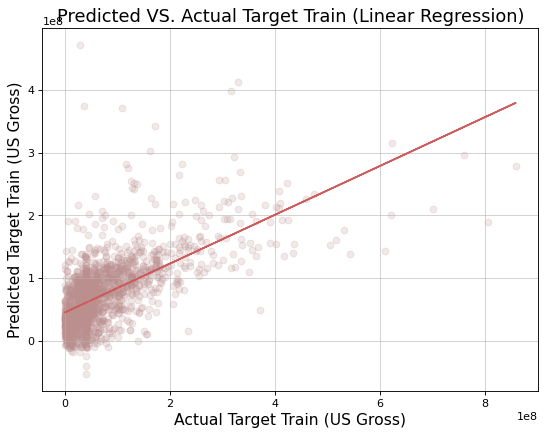

In [416]:
y_train_pred = lr.predict(X_train)
figure(figsize=(8, 6), dpi=80)

plt.scatter(y_train, y_train_pred, alpha=0.2, color='rosybrown')

m, b = np.polyfit(y_train, y_train_pred, 1)
# m = slope 
# b = intercept

plt.plot(y_train, m*y_train + b, color='indianred')

plt.xlabel('Actual Target Train (US Gross)', fontsize=14)
plt.ylabel('Predicted Target Train (US Gross)', fontsize=14)
plt.title('Predicted VS. Actual Target Train (Linear Regression)', fontsize=16)
plt.grid(linewidth=0.5)

In [417]:
# linear regression - post log transformation of target 

In [418]:
#log_y = df_movies_edited['log_y']
#X = df_movies_edited.drop(['gross_earning','log_y'], axis = 1)
#X, X_test, y, y_test = train_test_split(X, log_y, test_size=0.2, random_state=40)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [419]:
#lr = LinearRegression() 
#lr.fit(X_train,y_train)

#print(f"Linear Regression post transformation Training Score: {lr.score(X_train,y_train)}") 
#print(f"Linear Regression post transformation Validation Score: {lr.score(X_val,y_val)}")

In [420]:
#linear regression Kfold

In [421]:
def linear_reg_kfold(X_train, y_train):
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 1000)
    #print Training score
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    print(f"K-fold Linear Regression Training Score: {round(lm.score(X_train, y_train), 9)}")

    #print Validation score
    valid_scores = cross_val_score(lm, X_train, y_train, cv=kf)
    print(f"K-fold Linear Regression Validation Mean Score: {round(np.mean(valid_scores), 9)}")
    return lm

In [422]:
linear_reg_kfold(X_train,y_train)

K-fold Linear Regression Training Score: 0.389285939
K-fold Linear Regression Validation Mean Score: 0.379048417


LinearRegression()

In [423]:
#Polynomial Regression of Degree 2

In [424]:
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

poly_model = LinearRegression()

In [425]:
X_train.head()

,year,time_minute,imdb_rating,metascore,vote,Approved,G,GP,M/PG,NC-17,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,Unrated,X
1852,74,93,8.1,57.624111,278860,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1043,78,90,6.5,66.000000,238327,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1038,55,93,6.7,51.000000,93169,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2067,66,111,7.1,69.000000,88887,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2904,76,111,5.3,46.000000,54058,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [426]:
poly_model.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression validation Score: {poly_model.score(X_val_poly, y_val):.8f}')

print(f'Degree 2 polynomial regression training Score: {poly_model.score(X_train_poly, y_train):.8f}')
print(f'Degree 2 polynomial regression testing Score: {poly_model.score(X_test_poly,y_test):.8f}')

Degree 2 polynomial regression validation Score: -0.07468319
Degree 2 polynomial regression training Score: 0.00471088
Degree 2 polynomial regression testing Score: -0.28099803


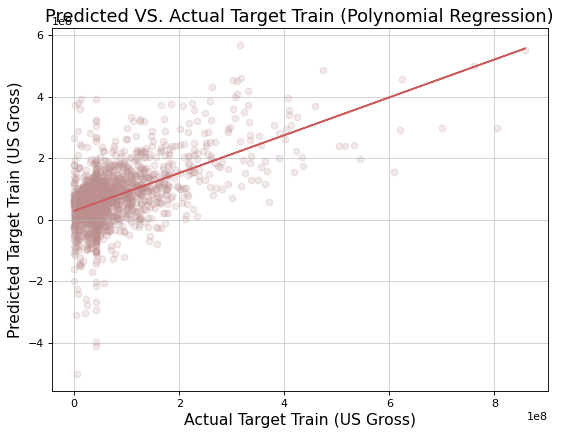

In [427]:
ypoly_train_pred = poly_model.predict(X_train_poly)
figure(figsize=(8, 6), dpi=80)

plt.scatter(y_train, ypoly_train_pred, alpha=0.2, color='rosybrown')

m, b = np.polyfit(y_train, ypoly_train_pred, 1)
# m = slope 
# b = intercept

plt.plot(y_train, m*y_train + b, color='indianred')

plt.xlabel('Actual Target Train (US Gross)', fontsize=14)
plt.ylabel('Predicted Target Train (US Gross)', fontsize=14)
plt.title('Predicted VS. Actual Target Train (Polynomial Regression)', fontsize=16)
plt.grid(linewidth=0.5)

In [428]:
#ridge regression

In [429]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

red_model = Ridge(alpha=1)

In [456]:
red_model.fit(X_train_scaled, y_train)

print(f'Ridge Regression validation Score: {red_model.score(X_val_scaled, y_val):.8f}')
print(f'Ridge Regression Training Score: {red_model.score(X_train_scaled, y_train):.8f}')


Ridge Regression validation Score: 0.46113795
Ridge Regression Training Score: 0.38928325


In [431]:
#Ridge Regression Cross-Validation

In [432]:
def ridge_model(X_train,y_train, regular_var = 1, CV_flag = False, cv_value = 5, alphavec = [1,10,20]):
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 1000)
    if CV_flag is True:
        m = RidgeCV(alphas = alphavec, cv = cv_value)
        m.fit(X_train, y_train)
    
        print("Best score:", m.best_score_)
    else:
        m = Ridge(alpha = regular_var) 
        m.fit(X_train, y_train )
        
        valid_scores = cross_val_score(m, X_train, y_train, cv=kf)
        print(f"Ridge Regression K-Fold Training Score: {round(m.score(X_train,y_train), 9)}")
        print(f"Ridge Regression K-Fold Validation Mean Score: {round(np.mean(valid_scores), 9)}")
    return m

In [447]:
ridge_model(X_train_scaled, y_train)

Ridge Regression K-Fold Training Score: 0.389283247
Ridge Regression K-Fold Validation Mean Score: 0.379102316


Ridge(alpha=1)

In [434]:
#lasso regression

In [449]:
def lasso_model(X_train,y_train, regular_var = 1, CV_flag = False, cv_value = 5, alphavec = [1,10,20]):
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 1000)
    if CV_flag is True:
        m = LassoCV(alphas = alphavec, cv = cv_value)
        m.fit(X_train, y_train)
        #print("mean error:", m.mse_path_)
    else:
        m = Lasso(alpha = regular_var, normalize=True, tol=1e-2) 
        m.fit(X_train, y_train )

    valid_scores = cross_val_score(m, X_train, y_train, cv=kf)
    print(f"Lasso Model Training Score: {round(m.score(X_train,y_train), 9)}")
    print(f"Lasso Model Validation Mean Score: {round(np.mean(valid_scores), 9)}")
    return m

In [450]:
lasso_model(X_train_scaled, y_train)

Lasso Model Training Score: 0.389285939
Lasso Model Validation Mean Score: 0.379048764


/Users/himanikaushik/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6987836413576397e+17, tolerance: 1.0698124934411718e+17
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1, normalize=True, tol=0.01)

In [437]:
#interaction only polynomial regression

In [438]:
poly = PolynomialFeatures(interaction_only = True) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

poly_model = LinearRegression()

In [439]:
poly_model.fit(X_train_poly, y_train)
print(f'Interaction only polynomial regression validation Score: {poly_model.score(X_val_poly, y_val):.8f}')

print(f'Interaction only polynomial regression training Score: {poly_model.score(X_train_poly, y_train):.8f}')
print(f'Interaction only polynomial regression testing Score: {poly_model.score(X_test_poly,y_test):.8f}')

Interaction only polynomial regression validation Score: 0.38008560
Interaction only polynomial regression training Score: 0.50838276
Interaction only polynomial regression testing Score: 0.31283438


In [440]:
# ridge regression on poly only interaction features

In [454]:
scaler2 = StandardScaler()

X_train_poly_scaled = scaler2.fit_transform(X_train_poly)
X_val_poly_scaled = scaler2.transform(X_val_poly)
X_test_poly_scaled = scaler2.transform(X_test_poly)

red_model2 = Ridge(alpha=1)

In [455]:
red_model2.fit(X_train_poly_scaled, y_train)

print(f'Ridge Regression on poly interaction only validation Score: {red_model2.score(X_val_poly_scaled, y_val):.8f}')
print(f'Ridge Regression on poly interaction only Training Score: {red_model2.score(X_train_poly_scaled, y_train):.8f}')
print(f'Ridge Regression on poly interaction only Testing Score: {red_model2.score(X_test_poly_scaled, y_test):.8f}')

Ridge Regression on poly interaction only validation Score: 0.54744346
Ridge Regression on poly interaction only Training Score: 0.61451453
Ridge Regression on poly interaction only Testing Score: 0.59082610


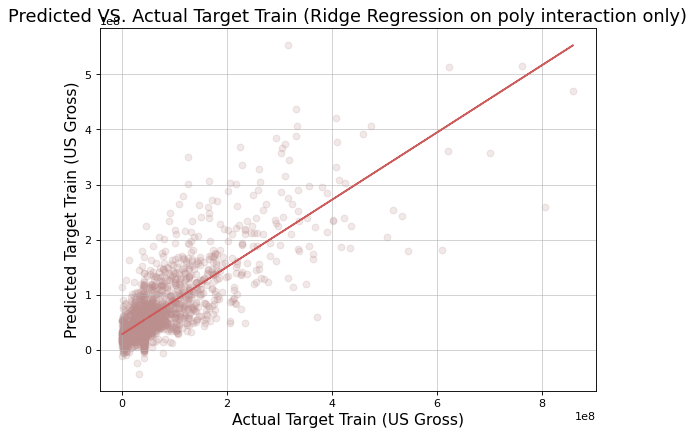

In [457]:
yridgepoly_train_pred = red_model2.predict(X_train_poly_scaled)
figure(figsize=(8, 6), dpi=80)

plt.scatter(y_train, yridgepoly_train_pred, alpha=0.2, color='rosybrown')

m, b = np.polyfit(y_train, yridgepoly_train_pred, 1)
# m = slope 
# b = intercept

plt.plot(y_train, m*y_train + b, color='indianred')

plt.xlabel('Actual Target Train (US Gross)', fontsize=14)
plt.ylabel('Predicted Target Train (US Gross)', fontsize=14)
plt.title('Predicted VS. Actual Target Train (Ridge Regression on poly interaction only)', fontsize=16)
plt.grid(linewidth=0.5)